In [2]:
import math
import torch
import gpytorch
import sys
sys.path.append("../cox-process/")
sys.path.append("../")
from cox_process import CoxProcess
from poisson_process import PoissonProcess
from gaussian_process import ExactGPModel

import matplotlib.pyplot as plt
import h5py
import numpy as np
from kernels import SpaceKernel
from torch.nn.functional import softplus

In [3]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, lh):
        super().__init__(train_x, train_y, lh)
        # Define mean and kernel
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = SpaceKernel()

    def forward(self, times):
        mean = self.mean_module(times)
        covar = self.covar_module(times)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [4]:
r_bao = torch.tensor(100/0.7/1000) # Gpc
w_bao = torch.tensor(15/0.7/1000) # Gpc
print(r_bao)
print(w_bao)
raw_r_bao = torch.log(torch.exp(r_bao) - 1)
raw_w_bao = torch.log(torch.exp(w_bao) - 1)

lh = gpytorch.likelihoods.GaussianLikelihood()
sample_model = GPModel(None, None, lh)

sample_model.covar_module.raw_gauss_mean.data = torch.log(torch.exp(r_bao) - 1)
sample_model.covar_module.raw_gauss_sig.data = torch.log(torch.exp(w_bao) - 1)

tensor(0.1429)
tensor(0.0214)


In [24]:
sample_model.eval()
lh.eval()

intense_pts = torch.linspace(0, 10, 200).unsqueeze(-1)
intense_vals = sample_model(intense_pts).sample(sample_shape=torch.Size((1,))).squeeze()

[]

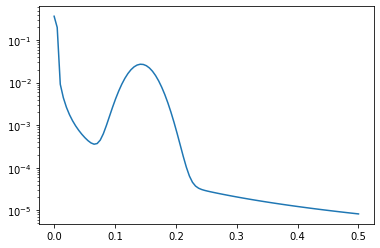

In [25]:
tau = torch.linspace(0, 0.5)
true_cov = sample_model.covar_module(tau, torch.zeros(1,1)).evaluate()
plt.plot(tau, true_cov.detach())
plt.semilogy()

## set up model and train

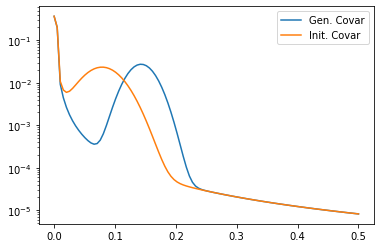

In [33]:
lh = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(intense_pts, intense_vals, lh)

start_cov = model.covar_module(tau, torch.zeros(1,1)).evaluate()
plt.plot(tau, true_cov.detach(), label="Gen. Covar")
plt.plot(tau,  start_cov.detach(), label="Init. Covar")
plt.semilogy()
plt.legend()

In [34]:
lh.train()
model.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(lh, model)

for i in range(300):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(intense_pts)
    # Calc loss and backprop gradients
    loss = -mll(output, intense_vals)
    loss.backward()
    optimizer.step()
    print(loss.item())

1.1410198211669922
1.1266626119613647
1.1129393577575684
1.0997473001480103
1.087028980255127
1.0748298168182373
1.0633175373077393
1.0527253150939941
1.0432474613189697
1.0346612930297852
1.026539921760559
1.0189069509506226
1.0119938850402832
1.0060495138168335
1.0009287595748901
0.9962236285209656
0.9918065071105957
0.9879176616668701
0.9849274158477783
0.9822595119476318
0.9794914722442627
0.9773362874984741
0.9757828712463379
0.9738918542861938
0.9724699258804321
0.9715297818183899
0.97014981508255
0.9695320725440979
0.9686678051948547
0.9679933190345764
0.9677600264549255
0.9671798944473267
0.9668431282043457
0.9667303562164307
0.9664790630340576
0.9715670943260193
0.9695897102355957
0.9658566117286682
0.9716481566429138
0.9720169305801392
0.971923291683197
0.9718329906463623
0.9717540144920349
0.9716848731040955
0.9716284275054932
0.9716079831123352
0.9716829061508179
0.9718891978263855
0.9720646739006042
0.971954882144928
0.9716739654541016
0.9714648723602295
0.9713632464408875

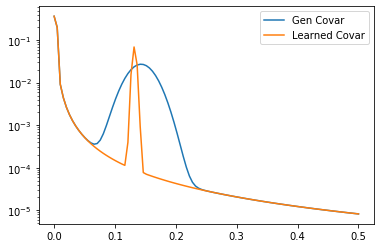

In [36]:
end_cov = model.covar_module(tau, torch.zeros(1,1)).evaluate()
plt.plot(tau, true_cov.detach(), label="Gen Covar")
plt.plot(tau,  end_cov.detach(), label="Learned Covar")
plt.semilogy()
plt.legend()